In [52]:
from models.get_model import get_model
import os
import sys
import numpy as np

In [2]:
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
# note: __file__ does not work in Jupyter Notebook!

# Data

In [5]:
# from utils two functions to prepare the data!

def get_index_from_one_hot_label(label):
    for i in range(0, len(label)):
        if label[i] == 1:
            return [i]
        
def get_even_odd_from_one_hot_label(label):
    for i in range(0, len(label)):
        if label[i] == 1:
            c = i % 2
            if c == 0:
                c = 1
            elif c == 1:
                c = -1
            return c

In [6]:
def get_data(dataset, total_data, dataset_file_path=os.path.dirname(''), sim_round=None):

    if dataset == 'MNIST_ORIG_EVEN_ODD' or dataset == 'MNIST_ORIG_ALL_LABELS':
        #note: here we download mnist_extract --> see file!!
        from data_reader.mnist_extractor import mnist_extract

        if total_data > 60000:
            total_data_train = 60000
        else:
            total_data_train = total_data

        if total_data > 10000:
            total_data_test = 10000
        else:
            total_data_test = total_data

        if sim_round is None:
            start_index_train = 0
            start_index_test = 0
        else:
            start_index_train = (sim_round * total_data_train) % (max(1, 60000 - total_data_train + 1))
            start_index_test = (sim_round * total_data_test) % (max(1, 10000 - total_data_test + 1))

        train_image, train_label = mnist_extract(start_index_train, total_data_train, True, dataset_file_path)
        test_image, test_label = mnist_extract(start_index_test, total_data_test, False, dataset_file_path)
        
        #AH: we get the original values for training here - why - not sure!
        train_label_orig=[]
        for i in range(0, len(train_label)):
            label = get_index_from_one_hot_label(train_label[i])
            train_label_orig.append(label[0])

        if dataset == 'MNIST_ORIG_EVEN_ODD':
            for i in range(0, len(train_label)):
                train_label[i] = get_even_odd_from_one_hot_label(train_label[i])

        if dataset == 'MNIST_ORIG_EVEN_ODD':
            for i in range(0, len(test_label)):
                test_label[i] = get_even_odd_from_one_hot_label(test_label[i])
                
    else:
        raise Exception('Unknown dataset name.')

    return train_image, train_label, test_image, test_label, train_label_orig

In [7]:
#from data_reader main - this is what we want to use 
#NOte: train_label_orig has the numbers, the other labels are now either odd or even!

dataset = "MNIST_ORIG_EVEN_ODD"
total_data = 30000
dataset_file_path = "/Users/Anso/Code/Imperial_College/IndividualProject/adaptive-federated-learning/datasets"
train_image, train_label, test_image, test_label, train_label_orig = get_data(dataset, total_data, dataset_file_path)

# Model 

In [3]:
#from Config File

model_name = 'ModelSVMSmooth'

batch_size = 100  # 100  # Value for stochastic gradient descent
total_data = 60000  # 60000  #Value for stochastic gradient descent

In [4]:
# from server.py get model and start it

model = get_model(model_name)
if hasattr(model, 'create_graph'):
    model.create_graph(learning_rate=step_size)

In [57]:
# happens all in server as set 

dim_w = model.get_weight_dimension(train_image, train_label)
w_global_init = model.get_init_weight(dim_w)
w_global = w_global_init
print(len(w_global))

784


In [58]:
# initalise variables as in server

w_global_min_loss = None
loss_min = np.inf
prev_loss_is_min = False

In [59]:
# why is w_global divided by datalength? A Question for later

# FL System later - to be used

In [130]:
#information from config for it:
n_nodes = 5  # Specifies the total number of clients
MAX_CASE = 4  # Specifies the maximum number of cases, this should be a constant equal to 4

In [131]:
from util.utils import get_indices_each_node_case
indices_each_node_case = get_indices_each_node_case(n_nodes, MAX_CASE, train_label_orig)

In [43]:
print(len(indices_each_node_case))
# I think indices each node has 4 cases and depending on those the data is split!
# why do I need the four cases??

4


In [36]:
print(len(indices_each_node_case[0][0]))
print(len(indices_each_node_case[0][1]))
print(len(indices_each_node_case[0][2]))
print(len(indices_each_node_case[0][3]))
print(len(indices_each_node_case[0][4]))


6000
6000
6000
6000
6000


In [39]:
print(len(indices_each_node_case[1][0]))
print(len(indices_each_node_case[1][1]))
print(len(indices_each_node_case[1][2]))
print(len(indices_each_node_case[1][3]))
print(len(indices_each_node_case[1][4]))

5670
6398
6055
5948
5929


In [41]:
print(len(indices_each_node_case[2][0]))
print(len(indices_each_node_case[2][1]))
print(len(indices_each_node_case[2][2]))
print(len(indices_each_node_case[2][3]))
print(len(indices_each_node_case[2][4]))

30000
30000
30000
30000
30000


In [42]:
print(len(indices_each_node_case[3][0]))
print(len(indices_each_node_case[3][1]))
print(len(indices_each_node_case[3][2]))
print(len(indices_each_node_case[3][3]))
print(len(indices_each_node_case[3][4]))

5135
5124
5072
5850
8819


In [44]:
# need to find out why 4 cases???

# in Client code - running learning

In [74]:
# now in client code to let the model run
from util.sampling import MinibatchSampling

#taking one from the arrays above
indices_this_node = indices_each_node_case[2][0]
# set sim around artifically to 1 
sim = 1
# batch size is defined above = 100

# use w_global as w here
w = w_global


sampler = MinibatchSampling(indices_this_node, batch_size, sim)
data_size_local = len(indices_this_node)

In [66]:
type(sampler)

util.sampling.MinibatchSampling

In [71]:
sample_indices = sampler.get_next_batch()
train_indices = sample_indices

In [84]:
print(len(indices_this_node))
print(len(sample_indices))
# note 30000 indicies and each sample is 100 big! so I can do this 3000 times

30000
100


In [75]:
grad = model.gradient(train_image, train_label, w, train_indices)

In [85]:
len(grad)
# note grad is the same length as w, so are the new parameters!

784

In [86]:
loss_last_global = model.loss(train_image, train_label, w, train_indices)
loss_last_global

0.5

In [116]:
# Analyser code:
number_of_rounds = 300;
weights_tracker = np.empty([number_of_rounds, 1])

def get_average_from_weight(w):
    length_w = len(w)
    i = 0
    average = 0
    while i < length_w:
        average += w[i]
        i += 1
    average /= len(w)
    return average

In [117]:
get_average_from_weight(w)

-0.00024319964703760946

In [118]:
# note: I checked by printing that the indicies thanks to the get_next_batch function are different every time
# note: why this stepsize?
# why do we do accuracy on test set and loss on train set? 

i = 0
step_size = 0.01
while i < number_of_rounds:
    sample_indices = sampler.get_next_batch()
    train_indices = sample_indices
    grad = model.gradient(train_image, train_label, w, train_indices)
    loss_last_global = model.loss(train_image, train_label, w, train_indices)
    print('Loss:', loss_last_global)
    
    w = w - step_size * grad
    #capture w as an average over all parameters:
    average_w = get_average_from_weight(w)
    #store this average_w in array for plotting 
    weights_tracker[i] = average_w
    
    i += 1

Loss: 0.2535923086300088
Loss: 0.27379291908913894
Loss: 0.2401680009453534
Loss: 0.17898810720488842
Loss: 0.25595156057025636
Loss: 0.17729850249804635
Loss: 0.17482214439071173
Loss: 0.1753346042784475
Loss: 0.21173008571280177
Loss: 0.1749944057642918
Loss: 0.2060712753727045
Loss: 0.1693004003412218
Loss: 0.22739894665101862
Loss: 0.20292657839372452
Loss: 0.2594989034040225
Loss: 0.2252286889153805
Loss: 0.2884136014209285
Loss: 0.21322857617013669
Loss: 0.2961922665212676
Loss: 0.17892185545034966
Loss: 0.257767217285018
Loss: 0.28975445024452284
Loss: 0.22313134083068742
Loss: 0.21109452975010454
Loss: 0.27632994693880986
Loss: 0.23742507719699713
Loss: 0.2259402228041696
Loss: 0.1842443951010695
Loss: 0.22369867742093458
Loss: 0.23919719200168016
Loss: 0.21534308888816117
Loss: 0.22735773474780668
Loss: 0.23677440549043519
Loss: 0.3222950875413664
Loss: 0.2575071416991299
Loss: 0.22830162454314468
Loss: 0.24467139710331023
Loss: 0.21999212304064852
Loss: 0.22876855561937529
Lo

In [99]:
# important note for aggregation: w_global += w_local * data_size_local -> means that the aggregator
# takes in the w depending on how big the local dataset was and weights them that way

In [119]:
prediction_accuracy = model.accuracy(test_image, test_label, w)
print('Accuracy', prediction_accuracy)

Accuracy 0.8743


In [107]:
# my questions in order to continue

# Does the ML model run once or does the ML model run multiple times on each node before updating the global model
# What are the 4 cases?
# I think I will just replicate exactly what I did here now in the FL system - makes it easer
# simple first
# afterwards I can think about adapting again

# what do I want to do next? Let this run in FL enviornment and take into account the different weights
# and draw the weights in a plot!

# question: do we just want to have one update round locally before sending it to the central server?
# or do we want local learning and update rounds and then central learning?

# to make it malicious I have to think about how I can change some of the data?

# do I choose always min w, so if an update round does not improve accuracy I am going back to what was there before?
# does it make sense to use use_min_loss = true -> always use the minimum loss weights from local parameters?

#whats simround and how does it affect the data?

# note: currently loss is calculated in the client and then the value transfered to server and used there.
# Would maybe be better to calculate the loss with the new w directly in the server? Also with test data?

# Question to Datasize local: I am using this to determin the weight of the node, but do I not always use 100
# as a bacth size and therefore it's the same for any of the nodes and wouldn't matter?
# Or do I iterae through all the data before sending anything?

In [137]:
#ToDo:
# check how minibatchsampler works - if it just gets traind with 100 parameters
# check how the model works? I guess model is pretrainer so nothing to do with me right?
# include my analyser!
# it always chooses the same data (each time I run it), in order to proof my case, I need to variate the dat
# will be done in second step when I include malicious data!


#ToDO analyse:
# graphen glätten 
# iterate between loss calculation training and test data and see difference!!! discuss this!!!
# check with someone my std calculation!

ToDo Tomorrow:
# do cases as for loop and loop through it with initalising server & clients!!!
#-> then I can do the analysis in one go! (but also enable to disable!!)
# make csv with accuracy and loss values for each of these cases and make a graph were you can read through thm
# make csv with global weight for all of these cases for all rounds -> 21 lines see differences!
# analyse malicious nodes some how - discuss later!
# mark malicious node definitly!

# make client malicious with for loops and a boolean!




#Idee:
# könnte man nicht einen threshold bestimmen, wo lernen nicht mehr so wichtig ist und dann die update round
#frequency reduzieren?

Question Tiffany:

1. Why use training data to calculate loss? and not the test data?
2. Why use always the same data for each round and not make it random (to have different results each round)
3. 

Notes what to do tomorrow:

1. Fix STD?
2. Save Accuracy and Loss as well
3. implement a malicious client (make variables as if statement -> malicious = true or not true!)
4. in Config file determine how many malicious user and how much of the data should be malicious

In [136]:
4 ** 2

16

In [123]:
from matplotlib import pyplot as plt

def plot_weights(weights):
    plt.plot(weights)
    plt.title("Average weight per iteration")
    plt.xlabel("Update Round")
    plt.ylabel("Average Weight")
    plt.grid(axis="y", linewidth=0.5)

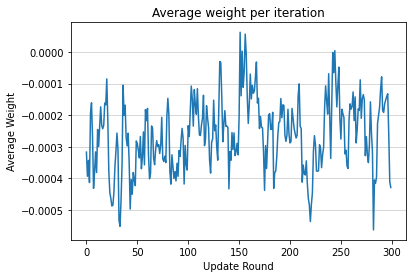

In [125]:
plot_weights(weights_tracker)

# Export Analysis 

In [173]:
current_directory = os. getcwd() 
results_file_name = os.path.join(current_directory, 'analysis_results/results.csv')

In [174]:
results_file_name

'/Users/Anso/Code/Imperial_College/IndividualProject/adaptive-federated-learning/analysis_results/results.csv'

In [212]:
test = np.zeros((3, 5))
test[0] = 1

In [213]:
test

array([[1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
# create a header file
# what do I want to save: std + mean weights + accuracy + loss 

Ich muss meine Analyse strukturieren: 
    1. std von weights 
    2. Accuracy & Loss pro Runde
    
    
Ich schau mir an was passiert, wenn keine node malicious ist vs:
    0 node malicious (base case)
    1 node malicious (25%, 50% 75% 100% der daten)
    2 node malicious (25%, 50%, 75%, 100% der daten)
    3 node malicious (25%, 50%, 75%, 100% der daten)
    4 node malicious(25%, 50%, 75%, 100% der daten)
    5 node malicious(25%, 50%, 75%, 100% der daten)

    1 basecase and 20 other cases -> 21 cases!
    
Was möchte ich dann vergleichen: 
    std of weights (save graph to check, can I put this together with average weight?)
    average weight (save graph to check, can I put this together with std?)
    accuracy per round -> graphs! (save graph to check)
    loss per round -> graphs! (save graph to check)

Find out: how to save graphs?
    
    Was möchte ich speichern: 
        Weights of normal and malicious users, I need to think about how to save it so that it
        is again accessable



In [217]:
with open(results_file_name, 'a') as csvfile:
    csvfile.write('test,test1,\n')
    csvfile.write(str(test))
    np.savetxt(csvfile, test, fmt='%.18e', delimiter=', ', encoding=None)
    csvfile.close()

In [ ]:
#what do I want to save: 
# for each round save the weights from each node for each round
# save in the header:accuracy and loss min and w global for it
# create unique identifier for each round which I can use as a key 